In [22]:
import numpy as np
x_train=np.load('/storage/ADHD200/athena/NYU/All_Data.npy')
Y=np.load('/storage/ADHD200/athena/NYU/All_Labels.npy')

In [ ]:
mask_img ='/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz'

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="/storage/nilearn_cache", 
                     memory_level=2)
masker.fit()


In [7]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 1
original_dim=x_train.shape[1]
latent_dim = 32
intermediate_dim = 500
epochs = 10
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(256, activation='tanh')(x)
h = Dense(128, activation='tanh')(h)
h = Dense(64, activation='tanh')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later

h_decoded = Dense(64, activation='tanh')(z)
h_decoded = Dense(128, activation='tanh')(h_decoded)
h_decoded = Dense(256, activation='tanh')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
from keras import optimizers
rmsprop=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.001)
vae.compile(optimizer=rmsprop)
vae.summary()


vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

encoder = Model(x, z_mean)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28546)        0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 256)          7308032     input_4[0][0]                    
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 128)          32896       dense_28[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 64)           8256        dense_29[0][0]                   
__________________________________________________________________________________________________
dense_31 (

In [8]:
decoder=Model(x, z)
y=decoder.predict(x_train,
        batch_size=batch_size)


(37152, 32)

(37152, 32)
(37152, 28546)


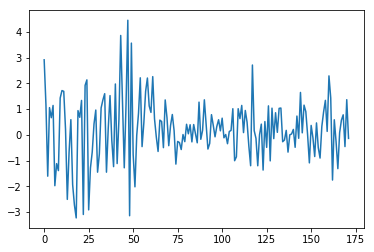

In [36]:
print(y.shape)
print(x_train.shape)
import numpy as np
t = range(0, 172)

import matplotlib.pyplot as plt
plt.plot(t, y[0:172,10])

In [10]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(y,x_train)
print(clf.coef_.shape)

(28546, 32)


In [11]:
#W=decoder_mean.get_weights()
#components_img=W[0]


In [18]:
import numpy as np
components=np.transpose(clf.coef_)
S = np.sqrt(np.sum(components ** 2, axis=1))
S[S == 0] = 1
components /= S[:, np.newaxis]

# Flip signs in each composant so that positive part is l1 larger
# than negative part. Empirically this yield more positive looking maps
# than with setting the max to be positive.
for component in components:
    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1
                

import numpy as np
components_img = masker.inverse_transform(components)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/segmentation.py:235: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  warnings.warn('Random walker only segments unlabeled areas, where '
/usr/local/lib/python3.5/dist-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use 

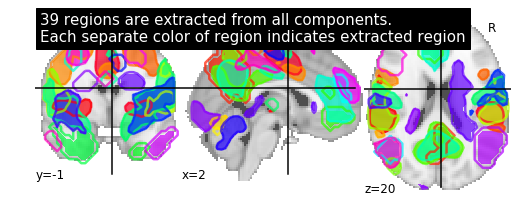

In [21]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=5000)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

from nilearn.plotting import plot_prob_atlas
# Visualization of region extraction results
title = ('%d regions are extracted from %s components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 'all'))
plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

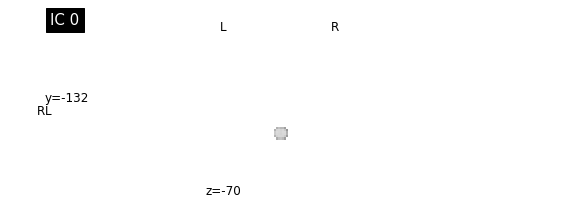

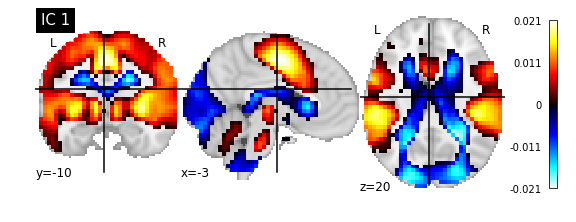

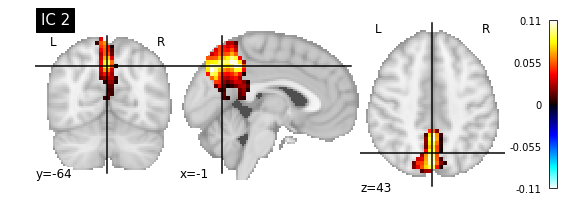

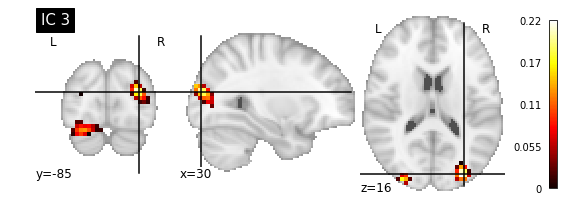

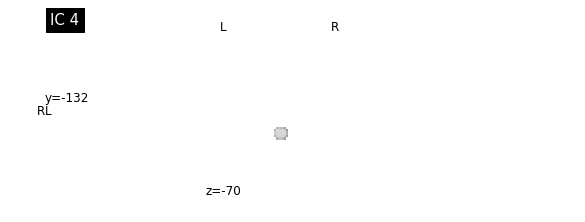

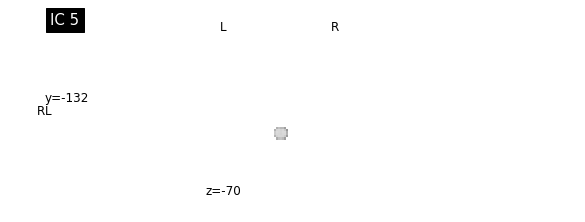

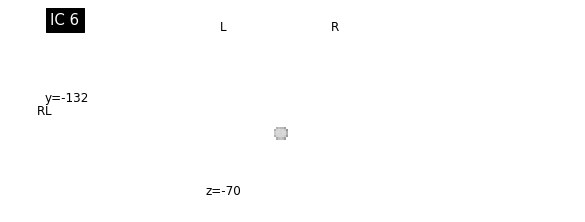

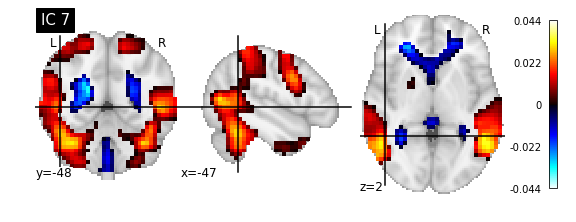

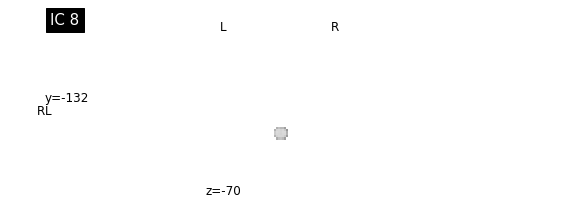

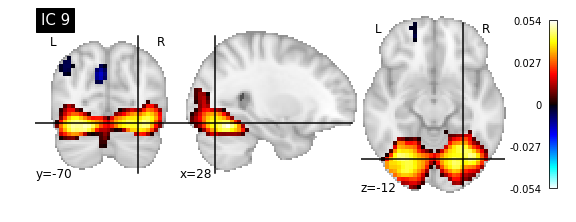

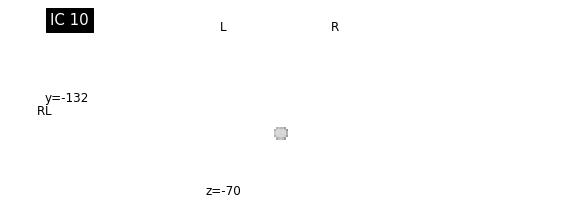

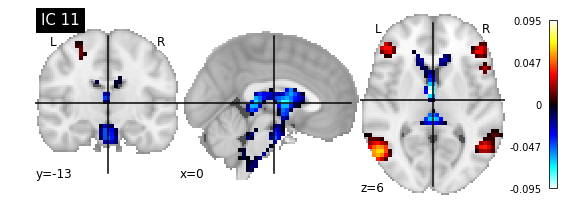

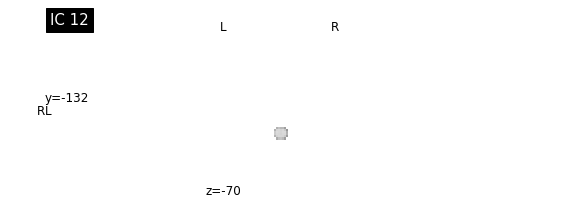

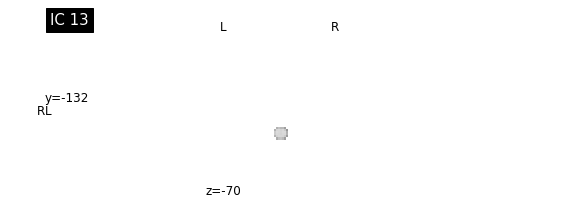

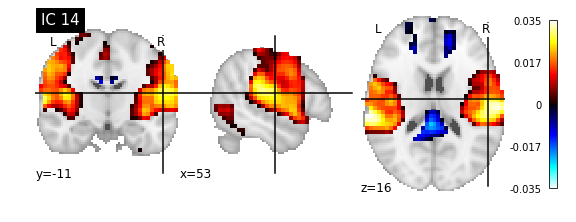

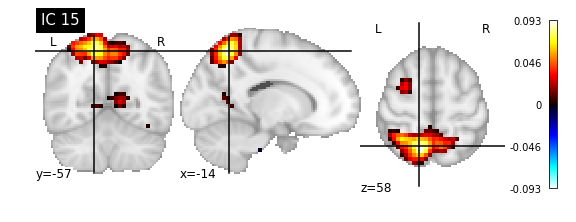

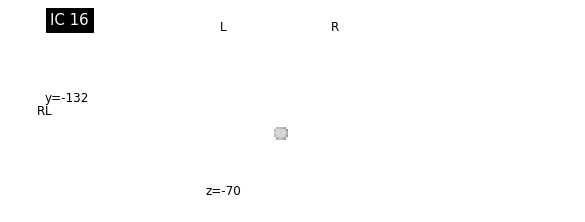

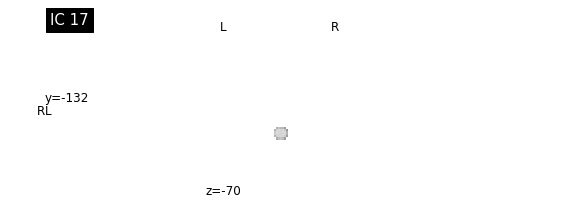

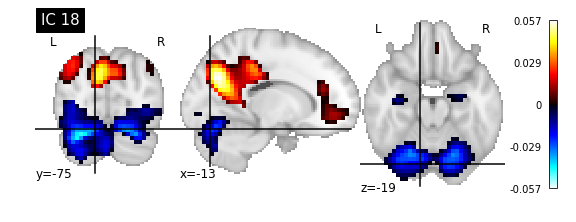

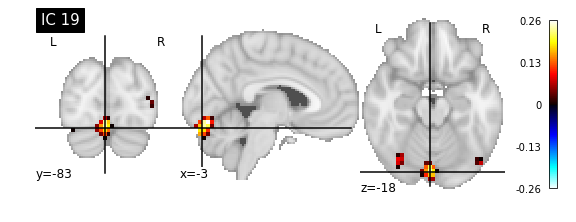

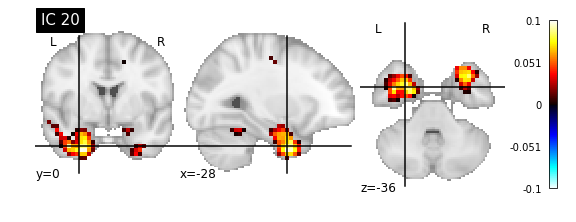

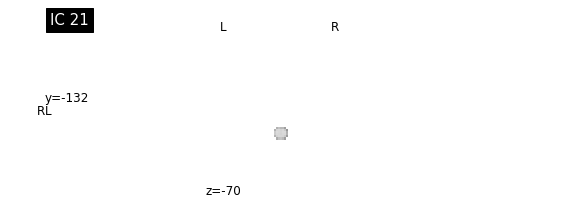

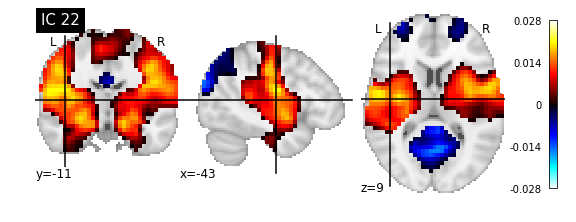

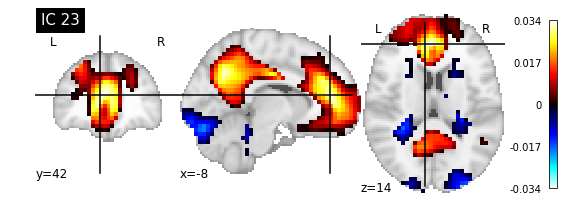

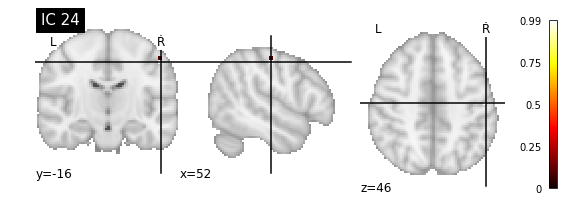

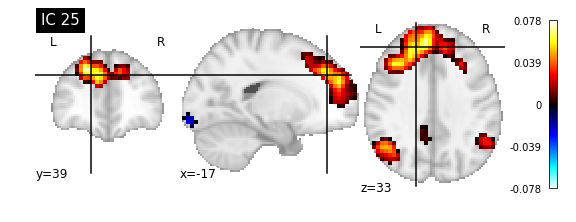

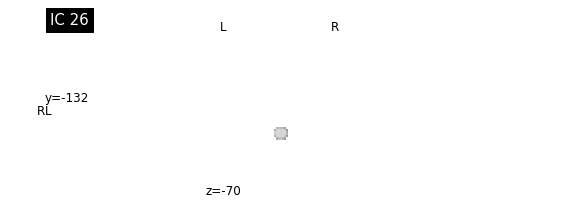

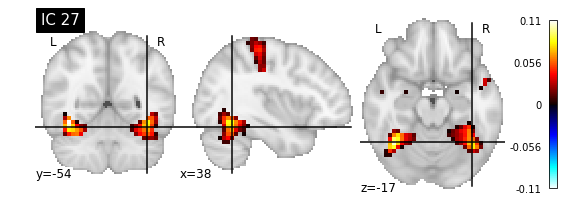

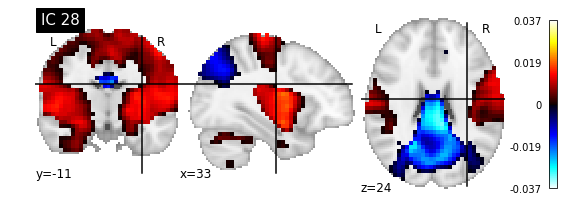

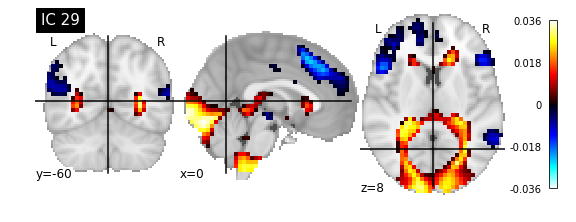

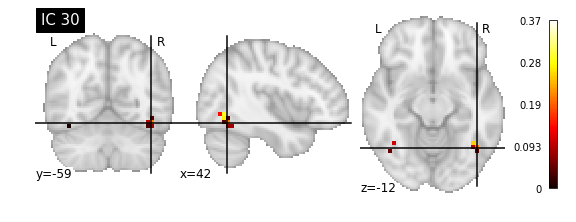

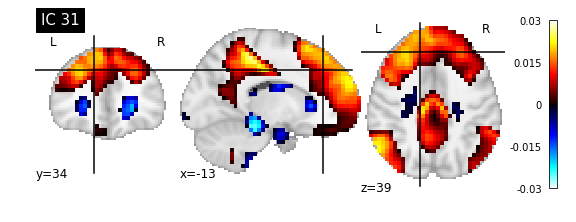

In [20]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()

In [23]:
import os
func_filenames=[]
for x in os.listdir('/storage/ADHD200/athena/NYU'):
    file='/storage/ADHD200/athena/NYU/'+str(x)+'/sfnwmrda'+str(x)+'_session_1_rest_1.nii.gz'
    #print(file)
    if os.path.isfile(file):
        func_filenames.append(file)  
    else:
        print(file)  
func_filenames=sorted(func_filenames)
print(len(func_filenames))

adhd_labels=Y  # 1 if ADHD, 0 if control

# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure

adhd_time_series = []
all_time_series = []

# Initializing ConnectivityMeasure object with kind='correlation'
correlation_measure = ConnectivityMeasure(kind='correlation')
for filename,is_adhd in zip(func_filenames,adhd_labels):
    print(filename)
    time_series = extractor.transform(filename)   
    all_time_series.append(time_series)
    if is_adhd:
        adhd_time_series.append(time_series)      

/storage/ADHD200/athena/NYU/All_Data.npy/sfnwmrdaAll_Data.npy_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/All_Labels.npy/sfnwmrdaAll_Labels.npy_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/All_Data_20.npy/sfnwmrdaAll_Data_20.npy_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/motion/sfnwmrdamotion_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz/sfnwmrdaADHD200_mask_152_4mm.nii.gz_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/NYU_phenotypic.csv/sfnwmrdaNYU_phenotypic.csv_session_1_rest_1.nii.gz
216
/storage/ADHD200/athena/NYU/0010001/sfnwmrda0010001_session_1_rest_1.nii.gz


/home/uga_qinglin/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


/storage/ADHD200/athena/NYU/0010002/sfnwmrda0010002_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010003/sfnwmrda0010003_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010004/sfnwmrda0010004_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010005/sfnwmrda0010005_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010006/sfnwmrda0010006_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010007/sfnwmrda0010007_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010008/sfnwmrda0010008_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010009/sfnwmrda0010009_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010010/sfnwmrda0010010_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010011/sfnwmrda0010011_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010012/sfnwmrda0010012_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010013/sfnwmrda0010013_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010014/sfnwmrda0010014_session_1_rest_1.nii.gz
/storage/ADH

/storage/ADHD200/athena/NYU/0010115/sfnwmrda0010115_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010116/sfnwmrda0010116_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010117/sfnwmrda0010117_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010118/sfnwmrda0010118_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010119/sfnwmrda0010119_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010120/sfnwmrda0010120_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010121/sfnwmrda0010121_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010122/sfnwmrda0010122_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010123/sfnwmrda0010123_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010124/sfnwmrda0010124_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010125/sfnwmrda0010125_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010126/sfnwmrda0010126_session_1_rest_1.nii.gz
/storage/ADHD200/athena/NYU/0010128/sfnwmrda0010128_session_1_rest_1.nii.gz
/storage/ADH

In [25]:
connectivity_biomarkers = {}

conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True)
connectivity_biomarkers = conn_measure.fit_transform(all_time_series)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers.shape[1]))


from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=3)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

from sklearn.model_selection import cross_val_score
mean_scores = []

for name, clf in zip(names, classifiers):
    cv_scores = cross_val_score(clf,
                                connectivity_biomarkers,
                                y=adhd_labels,
                                cv=cv,
                                groups=adhd_labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

780 correlation biomarkers for each subject.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:686: Use

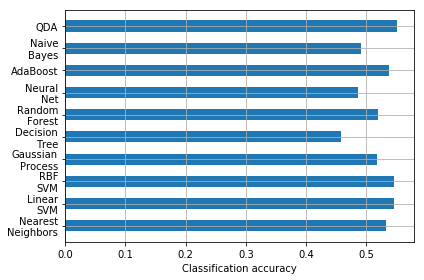

In [26]:
from nilearn.plotting import show
import numpy as np
import matplotlib.pylab as plt
plt.figure(figsize=(6, 4))
positions = np.arange(len(names)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [name.replace(' ', '\n') for name in names]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()